# Assignment: Data Wrangling
### `! git clone https://github.com/ds3001f25/wrangling_assignment.git`
### Do Q1 and Q2
### Reading material: `tidy_data.pdf`

In [1]:
! git clone https://github.com/cayang17/wrangling_assignment.git

%cd wrangling_assignment

Cloning into 'wrangling_assignment'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 24 (delta 3), reused 0 (delta 0), pack-reused 9 (from 2)
Receiving objects: 100% (24/24), 7.53 MiB | 20.03 MiB/s, done.
Resolving deltas: 100% (3/3), done.
/content/wrangling_assignment


**Q1.** This question provides some practice cleaning variables which have common problems.
1. Numeric variable: For `./data/airbnb_hw.csv`, clean the `Price` variable as well as you can, and explain the choices you make. How many missing values do you end up with? (Hint: What happens to the formatting when a price goes over 999 dollars, say from 675 to 1,112?)
2. Categorical variable: For the Minnesota police use of for data, `./data/mn_police_use_of_force.csv`, clean the `subject_injury` variable, handling the NA's; this gives a value `Yes` when a person was injured by police, and `No` when no injury occurred. What proportion of the values are missing? Is this a concern? Cross-tabulate your cleaned `subject_injury` variable with the `force_type` variable. Are there any patterns regarding when the data are missing?
3. Dummy variable: For the pretrial data covered in the lecture `./data/justice_data.parquet`, clean the `WhetherDefendantWasReleasedPretrial` variable as well as you can, and, in particular, replace missing values with `np.nan`.
4. Missing values, not at random: For the pretrial data covered in the lecture, clean the `ImposedSentenceAllChargeInContactEvent` variable as well as you can, and explain the choices you make. (Hint: Look at the `SentenceTypeAllChargesAtConvictionInContactEvent` variable.)

Price_clean summary:
count    30478.000000
mean       163.589737
std        197.785454
min         10.000000
25%         80.000000
50%        125.000000
75%        195.000000
max      10000.000000
Name: Price_clean, dtype: float64


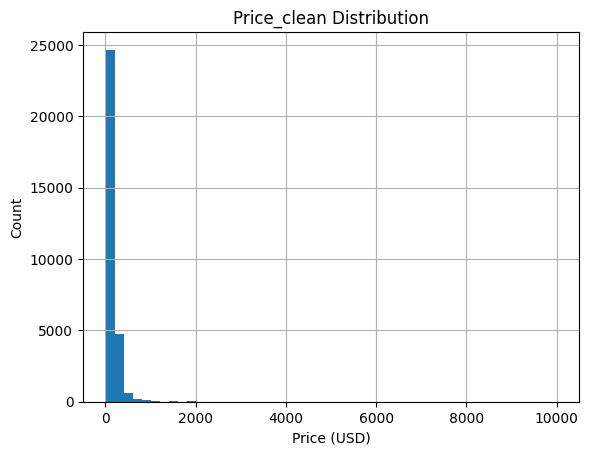

Saved cleaned dataframe to data/airbnb_hw_cleaned.parquet
Columns: ['response_datetime', 'problem', 'is_911_call', 'primary_offense', 'subject_injury', 'force_type', 'force_type_action', 'race', 'sex', 'age', 'type_resistance', 'precinct', 'neighborhood']
Shape: (12925, 13)
Missing proportion: 0.762
More than 20% missing. This could bias analysis.

Cross-tabulation of subject_injury_clean × force_type:
force_type            Baton  Bodily Force  Chemical Irritant  Firearm  \
subject_injury_clean                                                    
No                        0          1093                131        2   
Yes                       2          1286                 41        0   
NaN                       2          7051               1421        0   
All                       4          9430               1593        2   

force_type            Gun Point Display  Improvised Weapon  Less Lethal  \
subject_injury_clean                                                      
No   

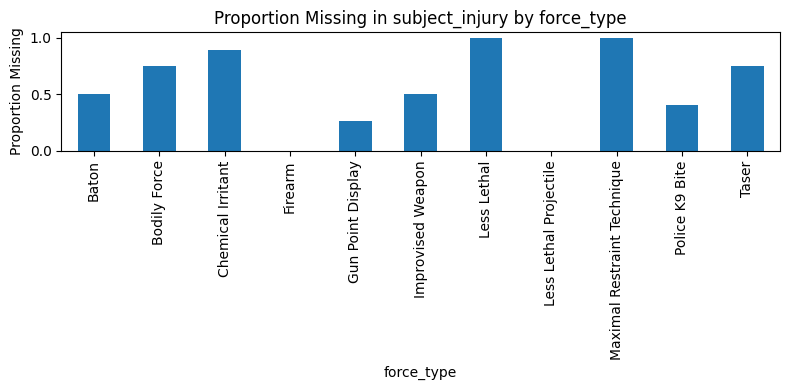

Columns: ['InternalStudyID', 'REQ_REC#', 'Defendant_Sex', 'Defendant_Race', 'Defendant_BirthYear', 'Defendant_Age', 'Defendant_AgeGroup', 'Defendant_AgeatCurrentArrest', 'Defendant_AttorneyTypeAtCaseClosure', 'Defendant_IndigencyStatus', 'Defendant_RecordedZipCode_eMag', 'Defendant_VirginiaResidencyStatus', 'WhetherDefendantWasReleasedPretrial', 'PretrialReleaseDate', 'DaysBetweenContactEventAndPretrialRelease', 'PretrialReleaseType1', 'PretrialReleaseType2', 'BondTypeAtInitialContact', 'BondAmountAtInitialContact', 'BondTypeAtRelease_v1', 'BondTypeatRelease_v2', 'BondAmountAtRelease', 'WhetherDefendantReceivedPretrialServicesAgencySuperv_PTCC', 'DaysBetweenReleaseandActivePretrialServicesAgencySupervDate', 'DaysBetweenPretrialServicesAgencySupervReferralDateandSupervDate', 'Indicator_PresumptiveDenialOfBail_19.2_120', 'Indicator_ConditionsToBeReleasedSecuredBond_19.2_123', 'IfReleasedonSecuredBond_TypeofSurety', 'Indicator_BailTermSetByCourt_eMag', 'AdditionalJailTimeServedAfterInitia

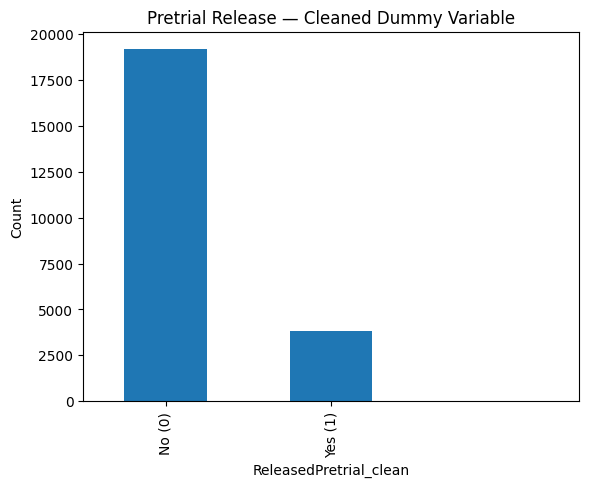

Before cleaning:
  ImposedSentenceAllChargeInContactEvent  \
0                                          
1                                     60   
2                                     12   
3                       .985626283367556   
4                                          
5                                     12   
6                                     36   
7                                      6   
8                                     24   
9                                     12   

   SentenceTypeAllChargesAtConvictionInContactEvent  
0                                                 9  
1                                                 0  
2                                                 1  
3                                                 1  
4                                                 4  
5                                                 0  
6                                                 1  
7                                                 0  
8           

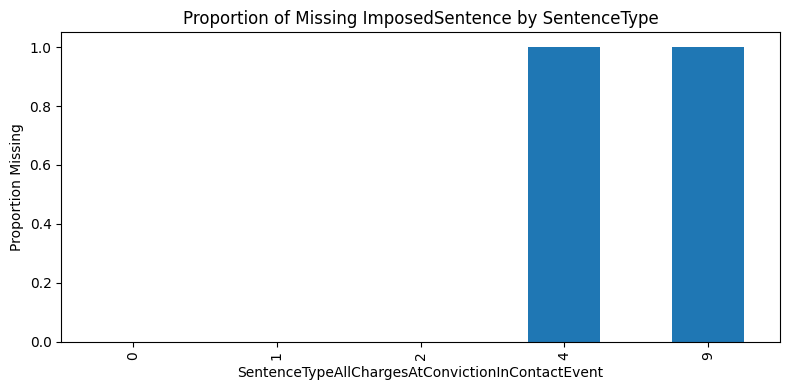


Interpretation:
- If certain sentence types (e.g., 'Dismissed', 'Not Guilty') have higher missingness,
  the missing values are *not random* — they depend on case outcome.
- Therefore, we should not impute these; instead, leave as np.nan and
  document that missingness is structurally meaningful.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

csv_path = Path("./data/airbnb_hw.csv")
if csv_path.exists():
    df = pd.read_csv(csv_path)

  # 1) Clean Price
    if "Price" in df.columns:
        df["Price_clean"] = (
            df["Price"]
            .astype(str)
            .str.replace(r"[$,]", "", regex=True)
            .str.strip()
        )
        df["Price_clean"] = pd.to_numeric(df["Price_clean"], errors="coerce")
        # Sanity check
        print("Price_clean summary:")
        print(df["Price_clean"].describe())

        # Visualize distribution without specifying colors
        plt.figure()
        df["Price_clean"].dropna().hist(bins=50)
        plt.title("Price_clean Distribution")
        plt.xlabel("Price (USD)")
        plt.ylabel("Count")
        plt.show()

    # Save cleaned output
    out_path = Path("./data/airbnb_hw_cleaned.parquet")
    df.to_parquet(out_path, index=False)
    print(f"Saved cleaned dataframe to {out_path}")

  # 2) Clean subject_injury

    mn_path = Path("./data/mn_police_use_of_force.csv")

    mn = pd.read_csv(mn_path)
    print("Columns:", list(mn.columns))
    print("Shape:", mn.shape)

    # Standardize column names
    mn.columns = mn.columns.str.strip().str.lower()

    # Confirm expected variables
    if "subject_injury" in mn.columns and "force_type" in mn.columns:
        # Normalize text
        mn["subject_injury_clean"] = (
            mn["subject_injury"]
            .astype(str)
            .str.strip()
            .str.lower()
            .replace({
                "yes": "Yes",
                "y": "Yes",
                "true": "Yes",
                "no": "No",
                "n": "No",
                "false": "No",
                "nan": np.nan,
                "": np.nan,
                "none": np.nan
            })
        )

        # Mark missing
        mn["subject_injury_clean"] = mn["subject_injury_clean"].replace("nan", np.nan)

        # Compute missing proportion
        missing_prop = mn["subject_injury_clean"].isna().mean()
        print(f"Missing proportion: {missing_prop:.3f}")

        # If missingness might be concerning
        if missing_prop > 0.2:
            print("More than 20% missing. This could bias analysis.")

        # Cross-tabulate with force_type
        ctab = pd.crosstab(mn["subject_injury_clean"], mn["force_type"], margins=True, dropna=False)
        print("\nCross-tabulation of subject_injury_clean × force_type:")
        print(ctab)

        # Visual pattern of missing data by force type
        plt.figure(figsize=(8,4))
        mn.groupby("force_type")["subject_injury_clean"].apply(lambda x: x.isna().mean()).plot(kind="bar")
        plt.title("Proportion Missing in subject_injury by force_type")
        plt.ylabel("Proportion Missing")
        plt.tight_layout()
        plt.show()

   # 3) clean WhetherDefendantWasReleasedPretrial
    jd_path = Path("./data/justice_data.parquet")

    jd = pd.read_parquet(jd_path)
    print("Columns:", list(jd.columns))
    jd.columns = jd.columns.str.strip()

    target = "WhetherDefendantWasReleasedPretrial"
    if target in jd.columns:
        # Normalize textual booleans and missing values
        jd["ReleasedPretrial_clean"] = (
            jd[target]
            .astype(str)
            .str.strip()
            .str.lower()
            .replace({
                "yes": 1,
                "true": 1,
                "y": 1,
                "no": 0,
                "false": 0,
                "n": 0,
                "nan": np.nan,
                "": np.nan,
                "none": np.nan
            })
        )
        jd["ReleasedPretrial_clean"] = jd["ReleasedPretrial_clean"].replace("nan", np.nan)
        jd["ReleasedPretrial_clean"] = pd.to_numeric(jd["ReleasedPretrial_clean"], errors="coerce")

        print(jd["ReleasedPretrial_clean"].value_counts(dropna=False))
        print(f"Missing values: {jd['ReleasedPretrial_clean'].isna().sum()} ({jd['ReleasedPretrial_clean'].isna().mean():.2%})")

        plt.figure()
        jd["ReleasedPretrial_clean"].value_counts(dropna=False).plot(kind="bar")
        plt.title("Pretrial Release — Cleaned Dummy Variable")
        plt.xticks([0,1], ["No (0)", "Yes (1)"])
        plt.ylabel("Count")
        plt.show()


  # 4) clean ImposedSentenceAllChargeInContactEvent

    jd = pd.read_parquet(jd_path)
    jd.columns = jd.columns.str.strip()

    imp_col = "ImposedSentenceAllChargeInContactEvent"
    ref_col = "SentenceTypeAllChargesAtConvictionInContactEvent"

    if imp_col in jd.columns and ref_col in jd.columns:
        print("Before cleaning:")
        print(jd[[imp_col, ref_col]].head(10))

        # Replace obvious placeholders or blanks with NaN
        jd[imp_col] = jd[imp_col].replace(["", " ", "NA", "N/A", "nan", "None"], np.nan)

        # Convert to numeric
        jd["ImposedSentence_clean"] = pd.to_numeric(jd[imp_col], errors="coerce")

        # Examine relationship between missing sentences and sentence type
        ctab = pd.crosstab(jd[ref_col], jd["ImposedSentence_clean"].isna(), normalize="index")
        print("\nProportion of ImposedSentence missing by SentenceType:")
        print(ctab)

        plt.figure(figsize=(8,4))
        ctab[True].plot(kind="bar")
        plt.title("Proportion of Missing ImposedSentence by SentenceType")
        plt.ylabel("Proportion Missing")
        plt.tight_layout()
        plt.show()

        print("\nInterpretation:")
        print(
            "- If certain sentence types (e.g., 'Dismissed', 'Not Guilty') have higher missingness,\n"
            "  the missing values are *not random* — they depend on case outcome.\n"
            "- Therefore, we should not impute these; instead, leave as np.nan and\n"
            "  document that missingness is structurally meaningful."
        )



**Q2.** Go to https://sharkattackfile.net/ and download their dataset on shark attacks (Hint: `GSAF5.xls`).

1. Open the shark attack file using Pandas. It is probably not a csv file, so `read_csv` won't work.
2. Drop any columns that do not contain data.
3. Clean the year variable. Describe the range of values you see. Filter the rows to focus on attacks since 1940. Are attacks increasing, decreasing, or remaining constant over time?
4. Clean the Age variable and make a histogram of the ages of the victims.
5. What proportion of victims are male?
6. Clean the `Type` variable so it only takes three values: Provoked and Unprovoked and Unknown. What proportion of attacks are unprovoked?
7. Clean the `Fatal Y/N` variable so it only takes three values: Y, N, and Unknown.
8. Are sharks more likely to launch unprovoked attacks on men or women? Is the attack more or less likely to be fatal when the attack is provoked or unprovoked? Is it more or less likely to be fatal when the victim is male or female? How do you feel about sharks?
9. What proportion of attacks appear to be by white sharks? (Hint: `str.split()` makes a vector of text values into a list of lists, split by spaces.)

Raw shape: (7049, 23)
Year range: 1000 to 2026


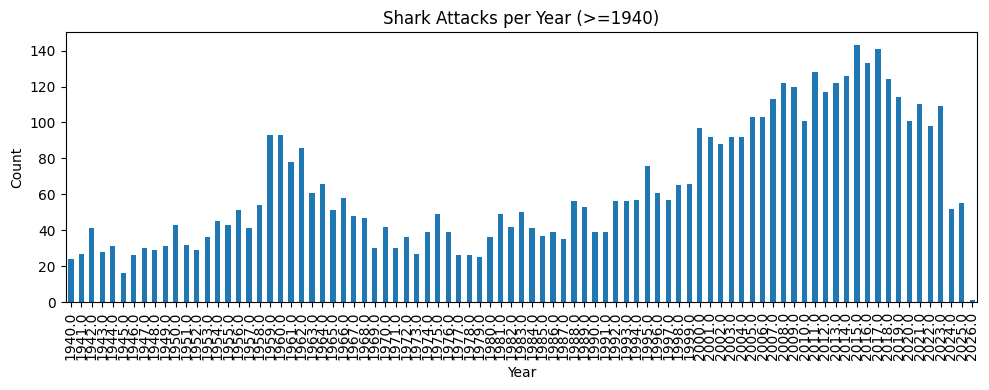

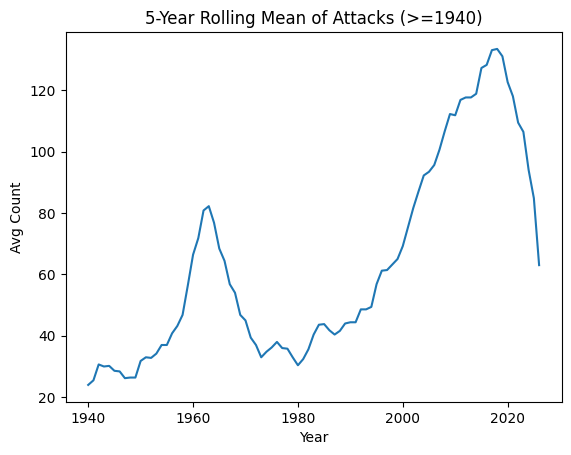


Age summary:
count    4010.000000
mean       28.141397
std        14.662060
min         1.000000
25%        17.000000
50%        24.000000
75%        37.000000
max        87.000000
Name: Age_clean, dtype: float64


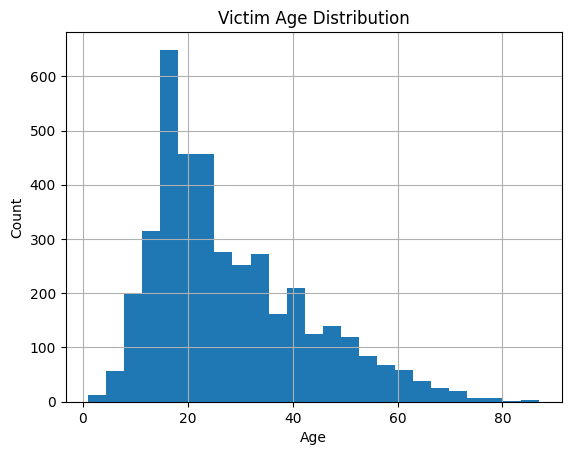


Proportion male (excluding missing): 0.803
Sex_norm
MALE      5658
FEMALE     807
NaN        584
Name: count, dtype: int64

Type_clean value counts:
Type_clean
Unprovoked       5203
Provoked          642
Invalid           552
Other/Unknown     377
Sea Disaster      242
Questionable       26
Boat                7
Name: count, dtype: int64


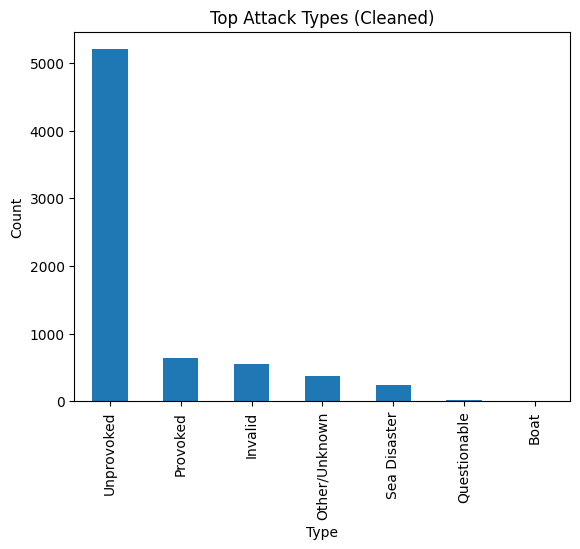

Fatal_clean value counts:
Fatal_clean
N          5485
Y          1484
Unknown      80
Name: count, dtype: int64
Proportion of male/female victims by Type:
Sex_norm         FEMALE      MALE
Type_clean                       
Invalid        0.135983  0.864017
Other/Unknown  0.081871  0.918129
Provoked       0.053265  0.946735
Questionable   0.160000  0.840000
Sea Disaster   0.051429  0.948571
Unprovoked     0.135876  0.864124

Fatality rates by Type:
Fatal_clean           N   Unknown         Y
Type_clean                                 
Boat           1.000000  0.000000  0.000000
Invalid        0.983696  0.001812  0.014493
Other/Unknown  0.933687  0.026525  0.039788
Provoked       0.959502  0.007788  0.032710
Questionable   0.615385  0.076923  0.307692
Sea Disaster   0.293388  0.004132  0.702479
Unprovoked     0.745724  0.011724  0.242552

Fatality rates by Victim Sex:
Fatal_clean         N   Unknown         Y
Sex_norm                                 
FEMALE       0.843866  0.004957  0.15

In [3]:
# 1) Download shark attack dataset
xls_path = Path("./data/GSAF5-2.xls")
df = pd.read_excel(xls_path)
print("Raw shape:", df.shape)

# 2) Drop columns that contain no data
def is_empty(col):
    return col.replace({"": np.nan, " ": np.nan}).isna().all()

empties = [c for c in df.columns if is_empty(df[c])]
if empties:
    print("Dropping empty columns:", empties)
    df = df.drop(columns=empties)

# 3) Clean Year variable
year_col = next((c for c in df.columns if "year" in c.lower()), None)
df["Year_clean"] = pd.to_numeric(df[year_col].astype(str).str.extract(r"(\d{3,4})")[0], errors="coerce")
yr = df["Year_clean"].dropna().astype(int)
print("Year range:", yr.min(), "to", yr.max())

since_1940 = df[df["Year_clean"] >= 1940]
counts = since_1940.groupby("Year_clean").size()

plt.figure(figsize=(10,4))
counts.plot(kind="bar")
plt.title("Shark Attacks per Year (>=1940)")
plt.xlabel("Year")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

rm = counts.rolling(5, min_periods=1).mean()
plt.figure()
rm.plot()
plt.title("5-Year Rolling Mean of Attacks (>=1940)")
plt.xlabel("Year")
plt.ylabel("Avg Count")
plt.show()

# 4) Clean Age variable
age_col = next((c for c in df.columns if "age" in c.lower()), None)
age = pd.to_numeric(df[age_col].astype(str).str.extract(r"(\d{1,3})")[0], errors="coerce")
df["Age_clean"] = age.where((age >= 0) & (age <= 110))
print("\nAge summary:")
print(df["Age_clean"].describe())

plt.figure()
df["Age_clean"].dropna().hist(bins=25)
plt.title("Victim Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

# 5) Proportion of victims who are male
sex_col = next((c for c in df.columns if "sex" in c.lower() or "gender" in c.lower()), None)
sex = df[sex_col].astype(str).str.strip().str.upper()
sex_norm = sex.replace({
    "M": "MALE", "MALES": "MALE",
    "F": "FEMALE", "FEMALES": "FEMALE"
})
df["Sex_norm"] = sex_norm.where(sex_norm.isin(["MALE", "FEMALE"]), np.nan)
prop_male = (df["Sex_norm"] == "MALE").mean(skipna=True)
print(f"\nProportion male (excluding missing): {prop_male:.3f}")
print(df["Sex_norm"].value_counts(dropna=False))

# 6) Clean Type variable
type_col = next((c for c in df.columns if "type" in c.lower()), None)
t = df[type_col].astype(str).str.strip().str.upper()
mapping = {
    "UNPROVOKED": "Unprovoked",
    "PROVOKED": "Provoked",
    "BOAT": "Boat",
    "SEA DISASTER": "Sea Disaster",
    "QUESTIONABLE": "Questionable",
    "INVALID": "Invalid"
}
df["Type_clean"] = t.map(mapping).fillna("Other/Unknown")
print("\nType_clean value counts:")
print(df["Type_clean"].value_counts().head(15))

plt.figure()
df["Type_clean"].value_counts().head(10).plot(kind="bar")
plt.title("Top Attack Types (Cleaned)")
plt.xlabel("Type")
plt.ylabel("Count")
plt.show()

# 7) Clean Fatal Y/N variable so it only takes three values: Y, N, and Unknown
fatal_col = next((c for c in df.columns if "fatal" in c.lower()), None)
fatal = df[fatal_col].astype(str).str.strip().str.upper()

def simplify_fatal(x):
    if x.startswith("Y"):
        return "Y"
    elif x.startswith("N"):
        return "N"
    else:
        return "Unknown"

df["Fatal_clean"] = fatal.apply(simplify_fatal)
print("Fatal_clean value counts:")
print(df["Fatal_clean"].value_counts(dropna=False))

# 8) Analyze relationships between Type, Sex, and Fatality

# A) Are sharks more likely to launch unprovoked attacks on men or women?
ct1 = pd.crosstab(df["Type_clean"], df["Sex_norm"], normalize="index")
print("Proportion of male/female victims by Type:")
print(ct1)

# B) Is an attack more or less likely to be fatal when provoked vs unprovoked?
ct2 = pd.crosstab(df["Type_clean"], df["Fatal_clean"], normalize="index")
print("\nFatality rates by Type:")
print(ct2)

# C) Is it more or less likely to be fatal for men vs women?
ct3 = pd.crosstab(df["Sex_norm"], df["Fatal_clean"], normalize="index")
print("\nFatality rates by Victim Sex:")
print(ct3)

# 9) What proportion of attacks appear to be by white sharks?
species_col = next((c for c in df.columns if "species" in c.lower()), None)

# Lowercase for matching, handle missing entries
species_lower = df[species_col].astype(str).str.lower().fillna("")

# Use str.split() to create lists of words per entry, then flatten check for 'white'
df["is_white_shark"] = species_lower.str.split().apply(lambda words: "white" in words)

prop_white = df["is_white_shark"].mean(skipna=True)
print(f"Proportion of attacks involving white sharks: {prop_white:.2%}")
